In [1]:
import argparse

from utils.logger import get_logger
from utils.arg_parser import Argments
from loader.data_loader import GeneralDataLoaderCls, NbsDataLoaderCls,\
                               GeneralDataLoaderSeg, NbsDataLoaderSeg,NbsDataLoaderRgs
from runners.cnn_runner import CnnRunner
from runners.nbs_runner import NbsRunner
from runners.mcd_runner import McdRunner
from models.regression import Reg_model
import torch
import numpy as np
from tqdm import tqdm
from runners.base_runner import gather_tensor

print(torch.cuda.is_available())

True


In [2]:
Reg_model

models.regression.Reg_model

In [3]:
from models.__init__ import _get_model

In [4]:
model = _get_model('Reg_model','nbs',1)

In [5]:
argparser = argparse.ArgumentParser()
# adding the values
argparser.add_argument("yaml")
argparser.add_argument("--phase", default="train", type=str) 
argparser.add_argument("--index", default=-1, type=int) 
argparser.add_argument("--gpus", default="0", type=str)
argparser.add_argument("--local_rank", default=-1, type=int) 
# save 
cmd_args = argparser.parse_args(["example_sin"])

arg = Argments(f"scripts/{cmd_args.yaml}.yaml", cmd_args) # stll many funcs to read
setup = arg['setup']
model_path = arg['path/model_path']
logger = get_logger(f"{model_path}/log.txt")

if setup['rank'] == 0:
    logger.info(arg)

model_type = setup['model_type']
dataset = arg['path/dataset']
is_seg = False

if 'nbs' in model_type: # added in n_a (comparing the else loop)
        
    _data_loader = NbsDataLoaderRgs # n_a exists
    data_loader = _data_loader(dataset, setup['batch_size'],
                                setup['n_a'], setup['cpus'], setup['seed'])
    runner = NbsRunner(data_loader, **arg.module, num_epoch=setup['num_epoch'], # core part 
                        logger=logger, model_path=model_path, rank=setup['rank'],
                        epoch_th=setup['epoch_th'], num_mc=setup['num_mc'],
                        adv_training=setup['adv_training'])

setting the python env
cmd_args.local_rank:  -1
torch.Size([100000, 1])
torch.Size([100000, 1])


In [6]:
runner.load('best.pth')
loader = runner.loader.load('test')
if runner.rank == 0:
    t_iter = tqdm(loader, total=runner.loader.len)
else:
    t_iter = loader

outputs = []
metrics = []
inputs = []
runner.model.eval()
for img, label in t_iter:
    _metric, output = runner._valid_a_batch(img, label, with_output=True)
    inputs += img.squeeze().tolist()
    outputs += output.cpu().mean(0).squeeze().tolist() # gather_tensor(output).cpu().numpy()
    metrics += [_metric.cpu().item()] # gather_tensor(_metric).cpu().numpy()
# labels = np.concatenate(labels)
# outputs = np.concatenate(outputs, axis=1)
err = np.mean(metrics[:])
# nll, brier = calc_nll_brier_mc(outputs, labels)
# print("Becarful, the num_class set as 1")
print(f"[Test] loss: {err:.5f} ")
# log += f"NLL : {nll:.2f}, Brier : {brier:.2f}"


[Test] loss: 0.04522 


In [7]:
import pandas as pd
df = pd.DataFrame({"inputs":inputs,"outputs":outputs})

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

n_train= 100000
n_test = 2000


train_X = (torch.rand((n_train,))-0.5)*5
train_y = 3. +torch.sin(train_X) + torch.randn(n_train)*0.05
test_X = (torch.rand((n_test,))-0.5)*5
test_y = 3. + torch.sin(test_X) + torch.randn(n_test)*0.05

train_X = train_X.unsqueeze(1)
train_y = train_y.unsqueeze(1)
test_X = test_X.unsqueeze(1)
test_y = test_y.unsqueeze(1)

# normalize
train_X = (train_X - train_X.mean())/train_X.std()
test_X = (test_X - test_X.mean())/test_X.std()

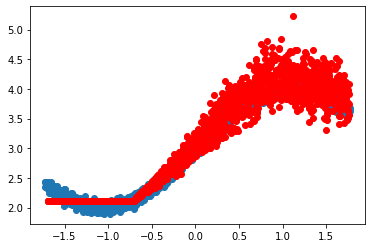

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.scatter(test_X.squeeze(),test_y.squeeze())
plt.scatter("inputs","outputs",data=df,color="red")
# plt.scatter(inputs,outputs,color="red")
plt.show()

In [10]:
outputs

[3.971254348754883,
 3.9623324871063232,
 2.6221487522125244,
 2.107862710952759,
 2.107862710952759,
 4.0929789543151855,
 3.4908394813537598,
 3.464587450027466,
 2.107862710952759,
 2.107862710952759,
 2.883441209793091,
 2.107862710952759,
 4.082334041595459,
 2.107862710952759,
 3.8606364727020264,
 3.6114134788513184,
 2.930373191833496,
 2.8993659019470215,
 3.897481918334961,
 4.346920013427734,
 2.80835223197937,
 3.8802876472473145,
 3.385772228240967,
 4.140931129455566,
 2.515662908554077,
 4.0580034255981445,
 2.107862710952759,
 2.906618118286133,
 2.107862710952759,
 2.1936142444610596,
 2.672672748565674,
 3.969724178314209,
 3.243938446044922,
 3.4166336059570312,
 3.1244683265686035,
 2.107862710952759,
 2.107862710952759,
 3.6876742839813232,
 2.107862710952759,
 4.300730228424072,
 3.0326952934265137,
 3.9083409309387207,
 3.639711380004883,
 3.908184051513672,
 2.107862710952759,
 3.6995856761932373,
 2.350958824157715,
 3.9219107627868652,
 4.0220537185668945,
 2.

In [11]:
### 마지막 레이어에 relu 빼자....
## 아예 activation을 tanh로 해보자. 